In [47]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(patchwork)
library(cowplot)
library(ggbreak)
library(scales)
if (!require(extrafont)) install.packages("extrafont")
library(extrafont)

# 3. 폰트 로드
loadfonts()
loadfonts(device = "pdf")  # pdf 출력을 위해

Scanning ttf files in /usr/share/fonts/ ...

Extracting .afm files from .ttf files...

/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf
 => /home/jerrylee/miniconda3/envs/r_env/lib/R/library/extrafontdb/metrics/DejaVuSans-Bold

/usr/share/fonts/dejavu/DejaVuSans-BoldOblique.ttf
 => /home/jerrylee/miniconda3/envs/r_env/lib/R/library/extrafontdb/metrics/DejaVuSans-BoldOblique

/usr/share/fonts/dejavu/DejaVuSans-ExtraLight.ttf
 => /home/jerrylee/miniconda3/envs/r_env/lib/R/library/extrafontdb/metrics/DejaVuSans-ExtraLight

/usr/share/fonts/dejavu/DejaVuSans-Oblique.ttf
 => /home/jerrylee/miniconda3/envs/r_env/lib/R/library/extrafontdb/metrics/DejaVuSans-Oblique

/usr/share/fonts/dejavu/DejaVuSans.ttf
 => /home/jerrylee/miniconda3/envs/r_env/lib/R/library/extrafontdb/metrics/DejaVuSans

/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf
 => /home/jerrylee/miniconda3/envs/r_env/lib/R/library/extrafontdb/metrics/DejaVuSansCondensed-Bold

/usr/share/fonts/dejavu/DejaVuSansCondensed-BoldOblique.t

# Step 1. Load data

In [2]:
df_prediction <- fread(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/simulation/obj2/simulation.scenarios.tsv",
    sep = "\t"
)

head(df_prediction)

A_true,X_true,scenario,X,lower_X,upper_X
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
0.4,0.02,SC1,0.025776585,0.012060856,0.03935364
0.4,0.02,SC2,0.001936408,-0.010300307,0.01858264
0.4,0.02,SC3,0.039074958,0.021871130,0.05467987
0.4,0.02,SC4,0.016162659,0.003015871,0.03824083
0.4,0.02,SC1,0.031588547,0.013717674,0.04348933
0.4,0.02,SC2,0.028418641,0.013919892,0.04096459


In [3]:
df_prediction %>% 
    group_by(scenario) %>% 
    summarise(
        X = median(X),
        lower_X = median(lower_X),
        upper_X = median(upper_X)
    )


scenario,X,lower_X,upper_X
<chr>,<dbl>,<dbl>,<dbl>
SC1,0.01951010,0.0025464394,0.03623676
SC2,0.01734360,0.0006590988,0.03205073
SC3,0.02974023,0.0131746001,0.04497745
SC4,0.01805187,0.0018136436,0.03506002


# plot theme

In [48]:
# 공통 테마 함수 정의
get_nature_theme <- function() {
    theme_bw() +
    theme(
        # 전체적인 배경
        panel.background = element_rect(fill = NA, color = NA),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),  
        
        # 축 설정
        axis.line.x.top = element_blank(),
        axis.line.y.right = element_blank(),
        axis.line.x.bottom = element_line(color = "black", size = 0.3),  
        axis.line.y.left = element_line(color = "black", size = 0.3),    
        axis.text = element_text(size = 6.5, color = "black"),
        axis.title = element_text(size = 7.5, color = "black"),
        axis.ticks = element_line(size = 0.3),
        axis.ticks.length = unit(0.8, "mm"),
        
        # 범례 설정
        legend.margin = margin(1, 1, 1, 1, unit = "mm"),
        # legend.spacing.y = unit(0.1, "cm"),
        
        # 여백 설정
        # plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
        plot.margin = margin(0, 0, 0, 0)
    ) + 
    # Arial
    theme(
        # 기본 텍스트 설정
        text = element_text(family = "Arial"),
        
        # 축 제목
        axis.title = element_text(family = "Arial", size = 10),
        
        # 축 텍스트
        axis.text = element_text(family = "Arial", size = 8),
        
        # 범례
        legend.text = element_text(family = "Arial", size = 8),
        legend.title = element_text(family = "Arial", size = 10),
        
        # 플롯 제목
        plot.title = element_text(family = "Arial", size = 10, face = "bold"),
        
        # 축 설정
        axis.line = element_line(colour = "black", size = 0.5),
        axis.ticks = element_line(colour = "black", size = 0.5),
        
        # 패널 설정
        panel.grid = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        
        # 여백 설정
        plot.margin = unit(c(5.5, 5.5, 5.5, 5.5), "points")
    )
}

# Step 2. Plot

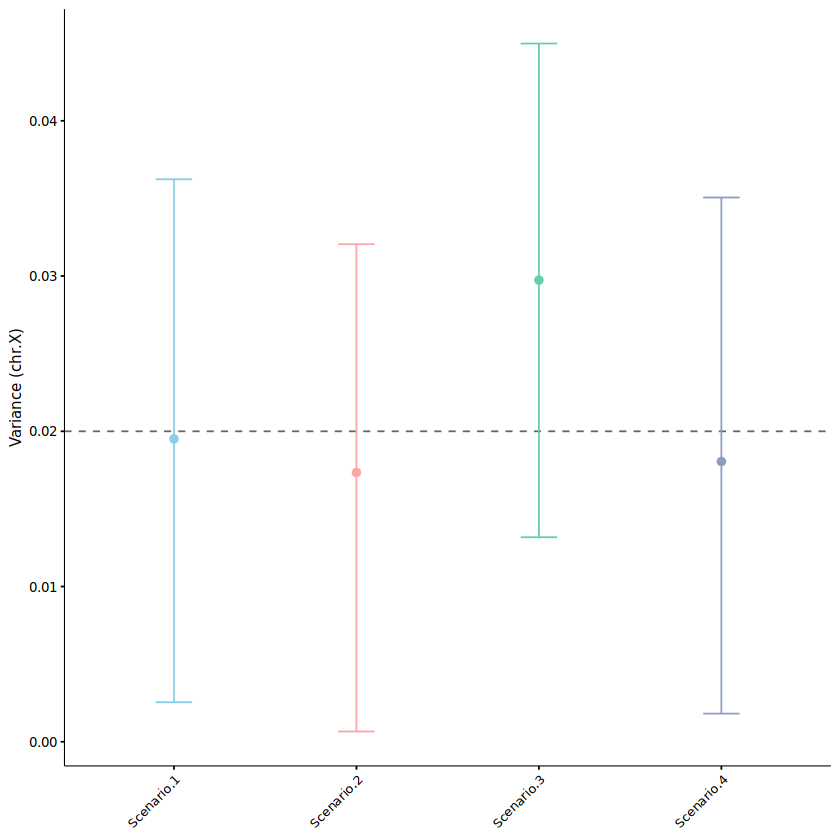

In [49]:
# 데이터 전처리 및 플로팅
plot_scenario_means <- function(data) {
    # 시나리오별 평균값 계산
    scenario_means <- data %>%
        group_by(scenario) %>%
        summarise(
            mean_X = median(X),
            mean_lower = median(lower_X),
            mean_upper = median(upper_X),
            .groups = 'drop'
        )
    
    # 시나리오별 색상 정의
    scenario_colors <- c(
        "SC1" = "#87CEEB",  
        "SC2" = "#F8A7A7",  # 빨간색
        "SC3" = "#66CDAA",  # 초록색
        "SC4" = "#8B9DC3"   # 남색
    )

    # 시나리오 이름 매핑 추가
    scenario_names <- c(
        "SC1" = "Scenario.1",
        "SC2" = "Scenario.2",
        "SC3" = "Scenario.3",
        "SC4" = "Scenario.4"
    )
    
    
    ggplot(scenario_means, aes(x = scenario, y = mean_X, color = scenario)) +
        # 실제 X_true 값을 수평선으로 표시
        geom_hline(
            yintercept = unique(data$X_true),
            linetype = "dashed",
            color = "gray40"
        ) +
        # 평균값을 점으로 표시
        geom_point(size = 2) +
        # CI를 에러바로 표시
        geom_errorbar(
            aes(ymin = mean_lower, ymax = mean_upper),
            width = 0.2
        ) +
        # 스타일링
        scale_color_manual(values = scenario_colors) +
        labs(
            x = "",  # X축 레이블을 비워둠으로써 없애버림
            y = "Variance (chr.X)"
        ) +
        get_nature_theme() +
        scale_x_discrete(labels = scenario_names) +  # x축 레이블 변경
        theme(
            legend.position = "none",
            plot.title = element_text(size = 10, face = "bold"),
            axis.text.x = element_text(
                family = "Arial",
                size = 8,
                angle = 45,           # 45도 회전
                hjust = 1             # 텍스트 정렬 조정
            ),
            axis.text.y = element_text(size = 8),
            axis.title.x = element_blank(),
            axis.title.y = element_text(size = 9)
        )
}

p <- plot_scenario_means(df_prediction)
p

In [50]:

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/simulation.X-scenario.pdf"
)

ggsave(
    filename = output_path,
    plot = p,
    width = 50,
    height = 46,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)
